# Search Engine

透過先前訓練的crf 模型，進行ner，並對於資料進行搜尋

##### 電影資料來源來源 : 

Kaggle :

https://www.kaggle.com/datasets/jillanisofttech/imdb-top-250-eng-movies-dataset



## 引入預訓練模型
wor2vec

In [1]:

from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('pre-train-model/GoogleNews-vectors-negative300.bin.gz', binary=True)

## 引入資料

In [2]:
import pandas as pd
df = pd.read_csv('IMDB/IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df.head(1)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True


## 大小寫預處理

In [3]:


df['Genre_lower'] = df['Genre'].apply(lambda x: [i.strip().lower() for i in x.split(',')])
df['Actors_lower'] = df['Actors'].apply(lambda x: [i.strip().lower() for i in x.split(',')][:3])
df['Director_lower'] = df['Director'].apply(lambda x: [i.strip().lower() for i in x.split(',')])
df['Year_str'] = df['Year'].astype(str)

# 檢查是否正確應用
print(df[['Genre_lower', 'Actors_lower', 'Director_lower', 'Year_str']].head(3))

      Genre_lower                               Actors_lower  \
0  [crime, drama]  [tim robbins, morgan freeman, bob gunton]   
1  [crime, drama]     [marlon brando, al pacino, james caan]   
2  [crime, drama]   [al pacino, robert duvall, diane keaton]   

           Director_lower Year_str  
0        [frank darabont]     1994  
1  [francis ford coppola]     1972  
2  [francis ford coppola]     1974  


## 引入訓練模型

模型 : CRF， NER 預測

In [35]:
import pickle

def load_crf_model(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {file_path}")
    return model

# 從檔案載入您的CRF模型
crf = load_crf_model('self-train-model/crf_ner_model.pkl')

Model loaded from self-train-model/crf_ner_model.pkl


## NER 預測

包含特徵提取、視覺化

[('Directed', 'O'), ('by', 'O'), ('Denis', 'O'), ('Villeneuve', 'O'), ('the', 'O'), ('2016', 'O'), ('scifi', 'O'), ('film', 'O'), ('Arrival', 'O'), ('stars', 'O'), ('Amy', 'B-Actor'), ('Adams', 'I-Actor'), ('and', 'O'), ('explores', 'O'), ('themes', 'O'), ('of', 'O'), ('communication', 'O'), ('and', 'O'), ('time', 'O')]
('Directed', 'O')
('by', 'O')
('Denis', 'O')
('Villeneuve', 'O')
('the', 'O')
('2016', 'O')
('scifi', 'O')
('film', 'O')
('Arrival', 'O')
('stars', 'O')
('Amy', 'B-Actor')
('Adams', 'I-Actor')
('and', 'O')
('explores', 'O')
('themes', 'O')
('of', 'O')
('communication', 'O')
('and', 'O')
('time', 'O')


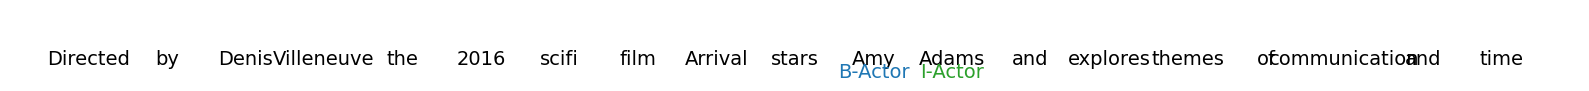

In [36]:


from sklearn.model_selection import train_test_split
import re
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score

def extract_features(sentence):
    tokens = sentence.split()
    features_list = []
    
    for i in range(len(tokens)):
        word = tokens[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = tokens[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
            })
        else:
            features['BOS'] = True
        
        if i < len(tokens) - 1:
            word1 = tokens[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
            })
        else:
            features['EOS'] = True
        
        features_list.append(features)
    
    return [features_list]

def predict(sentence, crf_model):
    features = extract_features(sentence)
    labels = crf_model.predict(features)
    return list(zip(sentence.split(), labels[0]))

# 使用您的句子進行預測
sentence = "Directed by Denis Villeneuve, the 2016 sci-fi film Arrival stars Amy Adams and explores themes of communication and time"
sentence = re.sub(r'[^\w\s]', '', sentence)
predicted_labels = predict(sentence, crf)
print(predicted_labels)


for i in predicted_labels:
    print(i)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def visualize_ner(sent, labels):
    words, tags = zip(*labels)
    unique_tags = list(set(tags))
    # 給每個標籤分配顏色，標籤'O'使用淺灰色，其他使用較鮮豔的顏色
    tag2color = {tag: f"C{i}" if tag != 'O' else "#dddddd" for i, tag in enumerate(unique_tags)}

    plt.figure(figsize=(16, 1))  # 調整畫布大小
    ax = plt.gca()
    
    # 計算單詞之間的間距
    space_between_words = 1
    x_positions = [i * space_between_words for i in range(len(words))]
    
    for i, (word, tag) in enumerate(zip(words, tags)):
        ax.text(x_positions[i], 0, word, color="black", fontsize=14, ha="center", va="bottom")
        # 僅當標籤不是'O'時才顯示顏色標籤
        if tag != 'O':
            ax.text(x_positions[i], 0.1, tag, color=tag2color[tag], fontsize=14, ha="center", va="top")
    
    ax.axis("off")
    ax.set_xlim([0 - space_between_words, x_positions[-1] + space_between_words])  # 調整x軸範圍以更好地適應文字
    plt.tight_layout()  # 這會自動調整子圖參數，以給定的填充適應畫布大小
    plt.show()

# 使用更新的可視化函數
visualize_ner(sentence, predicted_labels)

## 資料提取

### 去除 "O"

In [37]:
for i in predicted_labels:
    print(i)

print("=======================")
non_o_labels = [(word, label) for word, label in predicted_labels if label != 'O']

for word, label in non_o_labels:
    print(f"({word}, {label})")

('Directed', 'O')
('by', 'O')
('Denis', 'O')
('Villeneuve', 'O')
('the', 'O')
('2016', 'O')
('scifi', 'O')
('film', 'O')
('Arrival', 'O')
('stars', 'O')
('Amy', 'B-Actor')
('Adams', 'I-Actor')
('and', 'O')
('explores', 'O')
('themes', 'O')
('of', 'O')
('communication', 'O')
('and', 'O')
('time', 'O')
(Amy, B-Actor)
(Adams, I-Actor)


### 整理 B-I 關係

In [38]:
def extract_entities(predicted_labels, entity_type):
    entities = []
    current_entity = []
    
    for word, label in predicted_labels:
        if label == f"B-{entity_type}":
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
            current_entity.append(word)
        elif label == f"I-{entity_type}" and current_entity:
            current_entity.append(word)
        elif label == "O" and current_entity:
            entities.append(" ".join(current_entity))
            current_entity = []
    
    if current_entity:
        entities.append(" ".join(current_entity))
    
    return entities

actors = extract_entities(predicted_labels, "Actor")
directors = extract_entities(predicted_labels, "Director")
years = extract_entities(predicted_labels, "Year")
genres = extract_entities(predicted_labels, "Genre")

print("Actors:")
search_word = []
for actor in actors:
    print(f"Actor: {actor}")
    search_word.append(['Actor',actor])

print("\nDirector:")
for director in directors:
    print(f"Director: {director}")
    search_word.append(['Director',directors])

print("\nYears:")
for year in years:
    print(f"Year: {year}")
    search_word.append(['Year',year])

print("\nGenres:")
for genre in genres:
    print(f"Genre: {genre}")
    search_word.append(['Genre',genre])
print("=======================")
search_word = []
for actor in actors:
    print(f"Actor: {actor}")
    search_word.append(['Actors', actor])

print("\nDirectors:")
for director in directors:
    print(f"Director: {director}")
    search_word.append(['Director', director])

print("\nYears:")
for year in years:
    print(f"Year: {year}")
    search_word.append(['Year', year])

print("\nGenres:")
for genre in genres:
    print(f"Genre: {genre}")
    search_word.append(['Genre', genre])


Actors:
Actor: Amy Adams

Director:

Years:

Genres:
Actor: Amy Adams

Directors:

Years:

Genres:


## 結合ner之各類別預測

輸出搜尋結果 (近似關係的三項)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def vector_similarity_kinds(word, model):
    return model[word] if word in model else np.zeros(model.vector_size)

def calculate_max_similarity_kinds(search_term, words, model):
    search_terms = search_term.split()
    search_vectors = [vector_similarity_kinds(term, model) for term in search_terms]
    word_vectors = [vector_similarity_kinds(word, model) for word in words]

    max_similarity = 0
    for search_vector in search_vectors:
        if np.linalg.norm(search_vector) == 0:
            continue
        for word_vector in word_vectors:
            if np.linalg.norm(word_vector) == 0:
                continue
            similarity = cosine_similarity([search_vector], [word_vector])[0][0]
            max_similarity = max(max_similarity, similarity)
    
    return max_similarity

def recommend_similar_kinds(type_name, input_kind, df, model):
    type_names = type_name + 's'
    df[type_names] = df[type_name].apply(lambda x: ''.join(x))
    kinds = df[type_names].tolist()
    
    similarities = []
    for k in kinds:
        words = k.split()
        max_similarity = calculate_max_similarity_kinds(input_kind, words, model)
        similarities.append(max_similarity)

    sorted_indices = np.argsort(similarities)[::-1]
    recommended_kinds = set()
    recommended_kind_indices = []
    
    for idx in sorted_indices:
        current_kind = kinds[idx]
        if len(recommended_kind_indices) < 3 or similarities[idx] == 1:
            if current_kind not in recommended_kinds:
                recommended_kinds.add(current_kind)
                recommended_kind_indices.append(idx)

    recommended_movies = []
    for idx in recommended_kind_indices:
        kind = kinds[idx]
        print(f"'{input_kind}' 與 '{kind}' 最相似。 相似度分數: {similarities[idx]:.2f}")
        
        matching_indices = [i for i, k in enumerate(kinds) if k == kind]
        for idx in matching_indices:
            recommended_movies.append([df['Title'][idx], df['Director'][idx], df['Actors'][idx], df['Genre'][idx], df['Plot'][idx]])
    return recommended_movies


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def vector_similarity(word, model):
    return model[word] if word in model else np.zeros(model.vector_size)

def calculate_max_similarity(search_term, words, model):
    search_terms = search_term.split()
    search_vectors = [vector_similarity(term, model) for term in search_terms]
    word_vectors = [vector_similarity(word, model) for word in words]

    max_similarity = 0
    for search_vector in search_vectors:
        if np.linalg.norm(search_vector) == 0:
            continue
        for vec in word_vectors:
            if np.linalg.norm(vec) == 0:
                continue
            similarity = cosine_similarity([search_vector], [vec])[0][0]
            max_similarity = max(max_similarity, similarity)
    
    return max_similarity

def recommend_similar_genres(type_name, input_genre, df, model):
    if type_name == "Year":
        type_name = "Year_str"
        recommended_movies = df[df[type_name] == input_genre][['Title', 'Directors', 'Actors', 'Genre', 'Year_str', 'Plot']]
        recommended_movies_list = recommended_movies.values.tolist()
        
        if not recommended_movies_list:
            print(f"没有此年份電影 {input_genre}")
            return []
        print(f"有此年份電影 {input_genre}")
        return recommended_movies_list

    # type_name = type_name + '_lower'
    type_names = type_name + '_s'
    df[type_names] = df['Genre_lower'].apply(lambda x: ' '.join(x))
    print(df[type_names].head(3))
    genres = df[type_names].tolist()
    genres_name =  df[type_name].tolist()
    
    similarities = []
    for g in genres:
        words = g.split()
        max_similarity = calculate_max_similarity(input_genre, words, model)
        similarities.append(max_similarity)

    sorted_indices = np.argsort(similarities)[::-1]
    recommended_genres = set()
    recommended_genre_indices = []
    max_similarity = similarities[sorted_indices[0]]

    for idx in sorted_indices:
        if len(recommended_genre_indices) < 3 or similarities[idx] == 1:
            current_genre = genres[idx]
            if current_genre not in recommended_genres and current_genre != input_genre:
                recommended_genres.add(current_genre)
                recommended_genre_indices.append(idx)

    recommended_movies = []
    for idx in recommended_genre_indices:
        genre = genres[idx]
        print(f"'{input_genre}' 與 '{genre}' 最相似。 相似度分數: {similarities[idx]:.2f}")
        
        matching_indices = [i for i, g in enumerate(genres) if g == genre]
        for idx in matching_indices:
            recommended_movies.append([df['Title'][idx], df['Director'][idx], df['Actors'][idx], df['Genre'][idx], df['Year_str'][idx], df['Plot'][idx]])

    return recommended_movies

def handle_search(type_name, word):
    print("type = ",type_name,",word = ",word)
    if type_name == "Actors" or type_name == "Director":
        
        a = recommend_similar_kinds(type_name, word, df, word2vec_model)
        for movie in a:
            print(f"電影名称: {movie[0]}, 導演: {movie[1]}  演員: {movie[2]}  類型: {movie[3]},年份: {movie[4]}")
        print("================================")
        
        return
        
    a = recommend_similar_genres(type_name, word, df, word2vec_model)
    print("bbbbb")
    for movie in a:
        print(f"電影名称: {movie[0]}, 導演: {movie[1]}  演員: {movie[2]}  類型: {movie[3]},年份: {movie[4]}")
    print("================================")

# print(df['Genre_lower'])
for type_name, word in search_word:
    handle_search(type_name, word)

## 基於電影情節的近似內容推薦
使用bert

In [31]:
import numpy as np

# 讀取txt檔案
cosine_sim_matrix = np.loadtxt('matrix/sentence_transformers_cosine_similarity_matrix.txt')
print(cosine_sim_matrix)

[[1.       0.266089 0.137858 ... 0.144303 0.185403 0.18161 ]
 [0.266089 1.       0.39777  ... 0.092052 0.248535 0.241845]
 [0.137858 0.39777  1.       ... 0.150863 0.128789 0.1608  ]
 ...
 [0.144303 0.092052 0.150863 ... 1.       0.186039 0.120742]
 [0.185403 0.248535 0.128789 ... 0.186039 1.       0.137882]
 [0.18161  0.241845 0.1608   ... 0.120742 0.137882 1.      ]]


In [32]:
indices = pd.Series(df['Title'])

In [33]:
def recommend(title, cosine_sim = cosine_sim_matrix):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_5_indices = list(score_series.iloc[1:6].index)   # to get the indices of top 6 most similar movies
    # [1:6] to exclude 0 (index 0 is the input movie itself)
    
    print(cosine_sim)
    print()
    # print(cosine_sim_1)
    
    for i in top_5_indices:   # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append([list(df['Title'])[i],score_series[i],list(df['Genre'])[i]])
        
    return recommended_movies

# 打印结果
setience = recommend('The Maltese Falcon')
result = df[df['Title'] == 'The Maltese Falcon'][['Title','Genre','Director','Actors','Plot']]
print(result)
print()
for i in  (setience):
    print(i)

[[1.       0.266089 0.137858 ... 0.144303 0.185403 0.18161 ]
 [0.266089 1.       0.39777  ... 0.092052 0.248535 0.241845]
 [0.137858 0.39777  1.       ... 0.150863 0.128789 0.1608  ]
 ...
 [0.144303 0.092052 0.150863 ... 1.       0.186039 0.120742]
 [0.185403 0.248535 0.128789 ... 0.186039 1.       0.137882]
 [0.18161  0.241845 0.1608   ... 0.120742 0.137882 1.      ]]

                  Title               Genre     Director  \
150  The Maltese Falcon  Film-Noir, Mystery  John Huston   

                                                Actors  \
150  Humphrey Bogart, Mary Astor, Gladys George, Pe...   

                                                  Plot  
150  A private detective takes on a case that invol...  

['The Big Sleep', 0.522445, 'Crime, Film-Noir, Mystery']
['Chinatown', 0.502027, 'Drama, Mystery, Thriller']
['L.A. Confidential', 0.498361, 'Crime, Drama, Mystery']
['Double Indemnity', 0.448371, 'Crime, Drama, Film-Noir']
['Se7en', 0.439616, 'Crime, Drama, Mystery']
